# Introducción a Aplicaciones de Ciencia de Datos en Finanzas

## Trabajo Final

### Integrantes:

- Carla Dayan
- Juan Segundo Balbin
- Rodrigo Basavilbaso

### 🎯 Problema a abordar

El objetivo de este trabajo es desarrollar un modelo de detección de fraude en transacciones con tarjetas de crédito, utilizando técnicas de ciencia de datos sobre un conjunto real de datos altamente desbalanceado. Se busca identificar operaciones fraudulentas minimizando el costo total de errores, considerando la asimetría entre los falsos positivos y los falsos negativos.


In [1]:
# Librerías generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para modelado
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, roc_curve

# Benford's Law
from benfordslaw import benfordslaw

# Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Configuración de gráficos
sns.set(style='whitegrid')
%matplotlib inline


Se procede a hacer la carga de datos

In [2]:
# Carga de datos
df = pd.read_csv("data/fraudTest.csv")

# Dimensión del dataset
print(df.shape)

df.head()


(555719, 23)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


🔍 3. Análisis Exploratorio (EDA)
Distribución de la variable isFraud

Estadísticas descriptivas

Outliers y valores faltantes

Correlaciones y VIF

Clustering con PCA

Tests de Benford

is_fraud
0    0.99614
1    0.00386
Name: proportion, dtype: float64


[28-07-2025 22:37:23] [matplotlib.category] [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[28-07-2025 22:37:23] [matplotlib.category] [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


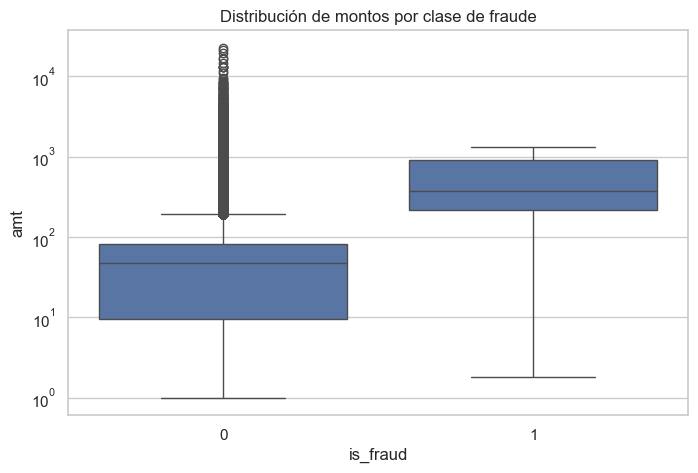

In [5]:
# Proporción de fraudes
print(df['is_fraud'].value_counts(normalize=True))

# Visualización de montos (filtrando valores no positivos y NaN)
df_plot = df[(df['amt'] > 0) & (~df['amt'].isna())]

plt.figure(figsize=(8,5))
sns.boxplot(data=df_plot, x='is_fraud', y='amt')
plt.yscale('log')
plt.title('Distribución de montos por clase de fraude')
plt.show()

📐 VIF

In [7]:
X = df.select_dtypes(include=np.number).drop(columns=['is_fraud'])
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data.sort_values('VIF', ascending=False)


,feature,VIF
5,long,5.827686
9,merch_long,5.777190
4,lat,1.038510
8,merch_lat,1.038091
0,Unnamed: 0,1.013188
3,zip,1.007560
1,cc_num,1.006899
6,city_pop,1.005905
2,amt,1.000017
7,unix_time,0.000106


Clustering con PCA + K-Means

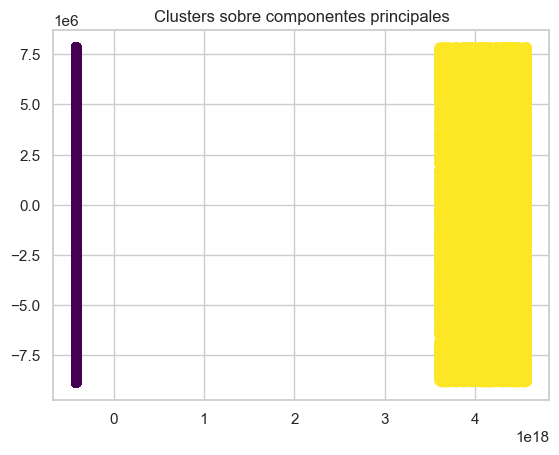

In [8]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X.fillna(0))
kmeans = KMeans(n_clusters=2, random_state=0).fit(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.title("Clusters sobre componentes principales")
plt.show()


🔢 Test de Benford

[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=60217.1


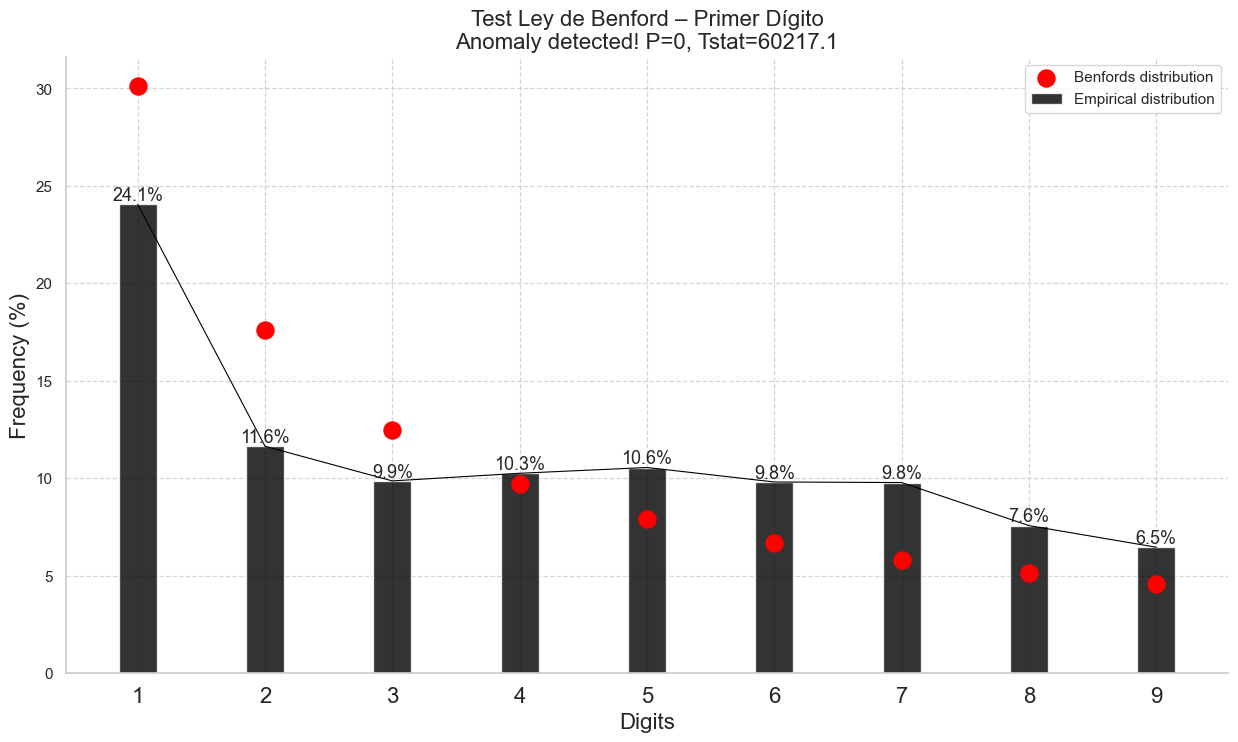

(<Figure size 1500x800 with 1 Axes>,
 <Axes: title={'center': 'Test Ley de Benford – Primer Dígito\nAnomaly detected! P=0, Tstat=60217.1'}, xlabel='Digits', ylabel='Frequency (%)'>)

In [10]:
bl = benfordslaw(alpha=0.05)
bl.fit(df['amt'])
bl.plot(title='Test Ley de Benford – Primer Dígito')


🛠️ 4. Ingeniería de Features
Imputación

Codificación

Transformaciones

In [11]:
# Ejemplo de imputación y codificación
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = df.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
  transformers=[
    ('num', SimpleImputer(strategy='median'), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
  ])


⚖️ 5. Modelado: Random Forest + Validación Cruzada

In [ ]:
# Separar variables
X = df.drop(columns='is_fraud')
y = df['is_fraud']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Definir features
num_features = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'is_fraud']
cat_features = df.select_dtypes(include=['object']).columns.tolist()

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# Pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# GridSearch
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [None],
    'classifier__min_samples_split': [2]
}

cv = StratifiedKFold(n_splits=3)
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)

🧮 6. Optimización de Umbral de Corte
(Esto lo implementás en Excel o podemos programarlo en Python)

In [ ]:
# Proba predicha
y_proba = grid_search.predict_proba(X_test)[:,1]
threshold = 0.15  # ajustar manualmente o con Solver

y_pred_thresh = (y_proba > threshold).astype(int)

# Matriz de confusión y costos
confusion_matrix(y_test, y_pred_thresh)


📈 7. Lift & Gain Charts

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lift curve")
plt.grid()
plt.show()


📤 8. Exportación de Resultados y Conclusiones

In [ ]:
results = pd.DataFrame({'true': y_test, 'proba': y_proba, 'pred': y_pred_thresh})
results.to_csv("predicciones_rf.csv", index=False)
